In [1]:
!pip install schedule

In [2]:
import schedule
import requests
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver as wd
from selenium.webdriver.common.by import By
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import datetime

In [3]:
def parsing():
    url = 'https://rosseti-lenenergo.ru/planned_work/'
    pages = requests.get(url)
    soup = BeautifulSoup(pages.text, 'lxml')
    table1 = soup.find('table', class_='tableous_facts funds')
    # print(table1)
    headers = []
    for i in table1.find_all('th')[:-4]:
        title = i.text
        headers.append(title)
        if len(headers) == 5 or len(headers) == 7:
            title += ' Время'
            headers.append(title)
    print(headers)

    mydata = pd.DataFrame(columns=headers)
    browser = wd.Chrome()
    browser.get('https://rosseti-lenenergo.ru/planned_work/')

    date_from = browser.find_element(By.ID, "fdate_tender_start")
    date_from.send_keys("18.09.2023")
    date_to = browser.find_element(By.ID, "fdate_tender_finish")
    date_to.send_keys("25.09.2023")
    find_but = browser.find_element(By.CLASS_NAME, "tenders__searchform-submit")
    find_but.click()

    for k in range(6):
        soup = BeautifulSoup(browser.page_source, 'lxml')
        table1 = soup.find('table', class_='tableous_facts funds')
        next_page = browser.find_element(By.CLASS_NAME, "next")
        for j in table1.find_all('tr')[2:]:
            row_data = j.find_all('td')
            row = [i.text for i in row_data]
            length = len(mydata)
            mydata.loc[length] = row
        next_page.click()

    print(mydata)
    mydata.to_csv('planned_works_Rosseti.csv', index=False)

In [4]:
def run():
    schedule.every().day.at('20:56').do(parsing)
    while True:
        schedule.run_pending()

In [5]:
from threading import Thread
thread = Thread(target=run)
thread.start()

In [6]:
mydata=pd.read_csv('planned_works_Rosseti.csv')
mydata

,"Регион РФ(область, край, город фед. значения, округ)",Административный район,Населённый пункт,Улица,Плановое время начала отключения электроснабжения,Плановое время начала отключения электроснабжения Время,Плановое время восстановления отключения электроснабжения,Плановое время восстановления отключения электроснабжения Время,Филиал,РЭС,Комментарий
0,Санкт-Петербург,Фрунзенский район,г. Санкт-Петербург,"Будапештская ул., д. 3, лит. А.",25-09-2023,11:00,25-09-2023,17:00,Кабельная сеть,Невский РЭС,NaN
1,Санкт-Петербург,Приморский район (СПб),Санкт-Петербург,ул. Долгоозерная д. 12 к. 2.,25-09-2023,11:00,25-09-2023,15:00,Кабельная сеть,Западный РЭС,NaN
2,Санкт-Петербург,Приморский район (СПб),Санкт-Петербург,"ул. Яхтенная д. 32 к. 2, ул. Яхтенная д. 32 к...",25-09-2023,10:00,25-09-2023,17:00,Кабельная сеть,Западный РЭС,NaN
3,Ленинградская область,Всеволожский район,"пром зона Птице фабрика невская, д. Аньялово.",NaN,25-09-2023,10:00,25-09-2023,17:00,Северные электрические сети,Сертоловский РЭС,NaN
4,Санкт-Петербург,Фрунзенский район,Санкт-Петербург,Волковский пр. д. 32,25-09-2023,10:00,25-09-2023,20:00,Кабельная сеть,Южный РЭС,NaN
...,...,...,...,...,...,...,...,...,...,...,...
295,Ленинградская область,Киришский район,СТ Рассвет,Полностью,19-09-2023,09:00,19-09-2023,17:00,Тихвинские ЭС,Тихвинский РЭС,NaN
296,Санкт-Петербург,Тихвинский район,"д.Овино(комплекс) , д.Овино ГРС",NaN,19-09-2023,09:00,19-09-2023,17:00,Тихвинские ЭС,Тихвинский РЭС,NaN
297,Ленинградская область,Всеволожский район,с/х Красный октябрь,-,19-09-2023,09:00,19-09-2023,18:00,Северные электрические сети,Всеволожский РЭС,NaN
298,Ленинградская область,Гатчинский район,Высоколючевой,NaN,19-09-2023,09:00,19-09-2023,18:00,Гатчинские ЭС,Гатчинский РЭС,Замена провода в пролете опор №54/8-54/12


In [7]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column                                                           Non-Null Count  Dtype 
---  ------                                                           --------------  ----- 
 0   Регион РФ(область, край, город фед. значения, округ)             299 non-null    object
 1   Административный район                                           298 non-null    object
 2   Населённый пункт                                                 300 non-null    object
 3   Улица                                                            181 non-null    object
 4   Плановое время начала отключения электроснабжения                300 non-null    object
 5   Плановое время начала отключения электроснабжения Время          300 non-null    object
 6   Плановое время восстановления отключения электроснабжения        300 non-null    object
 7   Плановое время восстановления отключения электроснабж

In [8]:
mydata=mydata.fillna('')
mydata['Id здания']=pd.Series(dtype='float64')
mydata['Координаты']=pd.Series(dtype='string')

In [9]:
size=len(mydata)
idx_to_del=[]
for i in range(size):
    flag=False
    cur_row=mydata.iloc[i]
    addresses=cur_row['Улица']
    adress = re.findall(r'[А-Яа-я]+[,\s\.]{1,5}[А-Яа-я]+[,\s\.\(]{1,5}\w+.{1,2}\d+[\s,]{0,2}[клит]{0,}[\.,\s]{0,5}\d{0,1}[А,Б]{0,1}', addresses)
    for ad in adress:
        url = 'https://geocode.gate.petersburg.ru/parse/free?street='+urllib.parse.quote(ad)
        response = requests.get(url,auth=('user','Bearer 1234'))
        result = response.text
        if result.find('error')==-1:
            flag=True
            b_id=response.json().get('Building_ID')
            coords='['+str(response.json().get('Latitude'))+','+str(response.json().get('Longitude'))+']'
            mydata=mydata.append(cur_row, ignore_index=True)
            mydata.loc[len(mydata)-1,'Id здания']=b_id
            mydata.loc[len(mydata)-1,'Улица']=ad
            mydata.loc[len(mydata)-1,'Координаты']=coords
    if adress and flag:
        idx_to_del.append(i)

mydata=mydata.drop(index=idx_to_del)       

C:\Users\Юля\AppData\Local\Temp\ipykernel_4060\2128275171.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mydata=mydata.append(cur_row, ignore_index=True)


In [10]:
mydata

,"Регион РФ(область, край, город фед. значения, округ)",Административный район,Населённый пункт,Улица,Плановое время начала отключения электроснабжения,Плановое время начала отключения электроснабжения Время,Плановое время восстановления отключения электроснабжения,Плановое время восстановления отключения электроснабжения Время,Филиал,РЭС,Комментарий,Id здания,Координаты
3,Ленинградская область,Всеволожский район,"пром зона Птице фабрика невская, д. Аньялово.",,25-09-2023,10:00,25-09-2023,17:00,Северные электрические сети,Сертоловский РЭС,,NaN,NaN
7,Ленинградская область,Бокситогорский район,"д. Васьково, д.Максимово, д. Платаново, д. О...",,25-09-2023,10:00,25-09-2023,13:00,Тихвинские ЭС,Бокситогорский РЭС,,NaN,NaN
8,Ленинградская область,Гатчинский район,"д. Покровская, д. Антелево",,25-09-2023,10:00,25-09-2023,17:00,Южные электрические сети,Пушкинский РЭС,,NaN,NaN
11,Ленинградская область,Волосовский район,"Пружицы, Голятицы",,25-09-2023,09:00,25-09-2023,17:00,Кингисеппские ЭС,Кингисеппский РЭС,,NaN,NaN
13,Ленинградская область,Тосненский район,г.Любань,"Октября, Калинина, Чкалова, Пушкина",25-09-2023,09:00,25-09-2023,18:00,Гатчинские ЭС,Тосненский РЭС,Обрезка крон деревьев.,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,Санкт-Петербург,Курортный район,п.Солнечное,"Лесная ул, д.11 ,",19-09-2023,09:00,19-09-2023,20:00,Северные электрические сети,Курортный РЭС,\nУстановка узла учета,85574.0,"[59.905565613,29.808562492]"
730,Санкт-Петербург,Курортный район,п.Солнечное,"Лесная ул, д.1 А",19-09-2023,09:00,19-09-2023,20:00,Северные электрические сети,Курортный РЭС,\nУстановка узла учета,33931.0,"[60.167696718,29.830972089]"
731,Санкт-Петербург,Курортный район,п.Солнечное,"Лесная ул, д.3 ,",19-09-2023,09:00,19-09-2023,20:00,Северные электрические сети,Курортный РЭС,\nУстановка узла учета,52051.0,"[59.880394656,29.842228231]"
732,Санкт-Петербург,Курортный район,п.Солнечное,"Лесная ул, д.1",19-09-2023,09:00,19-09-2023,20:00,Северные электрические сети,Курортный РЭС,\nУстановка узла учета,33931.0,"[60.167696718,29.830972089]"


In [11]:
mydata['Id здания'].info()

<class 'pandas.core.series.Series'>
Int64Index: 656 entries, 3 to 733
Series name: Id здания
Non-Null Count  Dtype  
--------------  -----  
434 non-null    float64
dtypes: float64(1)
memory usage: 10.2 KB


In [12]:
mydata.to_csv('planned_works_Rosseti_with_build_id.csv', index=False)

mydata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656 entries, 3 to 733
Data columns (total 13 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Регион РФ(область, край, город фед. значения, округ)             656 non-null    object 
 1   Административный район                                           656 non-null    object 
 2   Населённый пункт                                                 656 non-null    object 
 3   Улица                                                            656 non-null    object 
 4   Плановое время начала отключения электроснабжения                656 non-null    object 
 5   Плановое время начала отключения электроснабжения Время          656 non-null    object 
 6   Плановое время восстановления отключения электроснабжения        656 non-null    object 
 7   Плановое время восстановления отключения эле

In [13]:
districts = mydata['Административный район'].unique()
districts

array(['Всеволожский район', 'Бокситогорский район', 'Гатчинский район ',
       'Волосовский район', 'Тосненский район', 'Колпинский район',
       'Лодейнопольский район', 'Фрунзенский район',
       'Красногвардейский район', 'Ломоносовский район',
       'Приозерский район', 'Лужский район', 'Киришский район',
       'Кингисеппский район', 'Волховский район', 'Тихвинский район',
       'Приморский район (СПб)', 'Красносельский район',
       'Пушкинский район', 'Выборгский район (ЛО)',
       'Кировский район (ЛО)', 'Подпорожский район', '',
       'Калининский район', 'Выборгский район (СПб)',
       'Петроградский район', 'Курортный район', 'Невский район',
       'Московский район', 'Василеостровский район', 'Центральный район ',
       'Сланцевский район', 'Адмиралтейский район'], dtype=object)

In [14]:
mydata['Плановое время начала отключения электроснабжения'].unique()

array(['25-09-2023', '24-09-2023', '23-09-2023', '22-09-2023',
       '21-09-2023', '20-09-2023', '19-09-2023'], dtype=object)

In [15]:
mydata['Филиал'].unique()

array(['Северные электрические сети', 'Тихвинские ЭС',
       'Южные электрические сети', 'Кингисеппские ЭС', 'Гатчинские ЭС',
       'Новоладожские ЭС', 'Кабельная сеть', 'Выборгские ЭС', ''],
      dtype=object)

In [16]:
mydata['РЭС'].unique()

array(['Сертоловский РЭС', 'Бокситогорский РЭС', 'Пушкинский РЭС',
       'Кингисеппский РЭС', 'Тосненский РЭС', 'Колпинский РЭС',
       'Лодейнопольский РЭС', 'Южный РЭС', 'Правобережный РЭС',
       'Красносельский РЭС', 'Всеволожский РЭС', 'Ломоносовский РЭС',
       'Приозерский РЭС', 'Лужский РЭС', 'Тихвинский РЭС',
       'Волховский РЭС', 'Петродворцовый  РЭС', '', 'Гатчинский РЭС',
       'Западный РЭС', 'Рощинский РЭС', 'Выборгский РЭС', 'Восточный РЭС',
       'Невский РЭС', 'Островной РЭС', 'Курортный РЭС', 'Северный РЭС',
       'Песочинский РЭС', 'Центральный РЭС', 'Юго-Западный РЭС'],
      dtype=object)

In [17]:
mydata["Время начала отключения"] = mydata["Плановое время начала отключения электроснабжения"] +' '+ mydata["Плановое время начала отключения электроснабжения Время"]
mydata["Время начала отключения"]=pd.to_datetime(mydata['Время начала отключения'])

mydata["Время восстановления отключения"] = mydata["Плановое время восстановления отключения электроснабжения"] +' '+ mydata["Плановое время восстановления отключения электроснабжения Время"]
mydata["Время восстановления отключения"]=pd.to_datetime(mydata['Время восстановления отключения'])

date_labels=['Плановое время начала отключения электроснабжения','Плановое время начала отключения электроснабжения Время','Плановое время восстановления отключения электроснабжения','Плановое время восстановления отключения электроснабжения Время']
mydata=mydata.drop(date_labels, axis=1)

mydata['Код района']=mydata['Административный район'].apply(lambda x:  x[:4]+x[-5:] if x[:4]=='Выбо' else  x[:4]+x[6] if x[:4]=='Крас' else x[:4])
mydata['Код РЭС']=mydata['РЭС'].apply(lambda x: x[:4])
mydata['Код района'].unique()

array(['Всев', 'Бокс', 'Гатч', 'Воло', 'Тосн', 'Колп', 'Лоде', 'Фрун',
       'Красг', 'Ломо', 'Прио', 'Лужс', 'Кири', 'Кинг', 'Волх', 'Тихв',
       'Прим', 'Красс', 'Пушк', 'Выбо (ЛО)', 'Киро', 'Подп', '', 'Кали',
       'Выбо(СПб)', 'Петр', 'Куро', 'Невс', 'Моск', 'Васи', 'Цент',
       'Слан', 'Адми'], dtype=object)

In [18]:
mydata["Период отключения(в часах)"] = (mydata["Время восстановления отключения"] - mydata["Время начала отключения"]).dt.seconds//3600
mydata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656 entries, 3 to 733
Data columns (total 14 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   Регион РФ(область, край, город фед. значения, округ)  656 non-null    object        
 1   Административный район                                656 non-null    object        
 2   Населённый пункт                                      656 non-null    object        
 3   Улица                                                 656 non-null    object        
 4   Филиал                                                656 non-null    object        
 5   РЭС                                                   656 non-null    object        
 6   Комментарий                                           656 non-null    object        
 7   Id здания                                             434 non-null    float64   

In [19]:
mydata.describe()

,Id здания,Период отключения(в часах)
count,434.000000,656.000000
mean,79822.711982,9.182927
std,55844.396957,2.308976
min,234.000000,0.000000
25%,36413.250000,8.000000
50%,75730.000000,11.000000
75%,108818.500000,11.000000
max,224707.000000,13.000000


За сколько отключённых адресов отвественна каждая РЭС

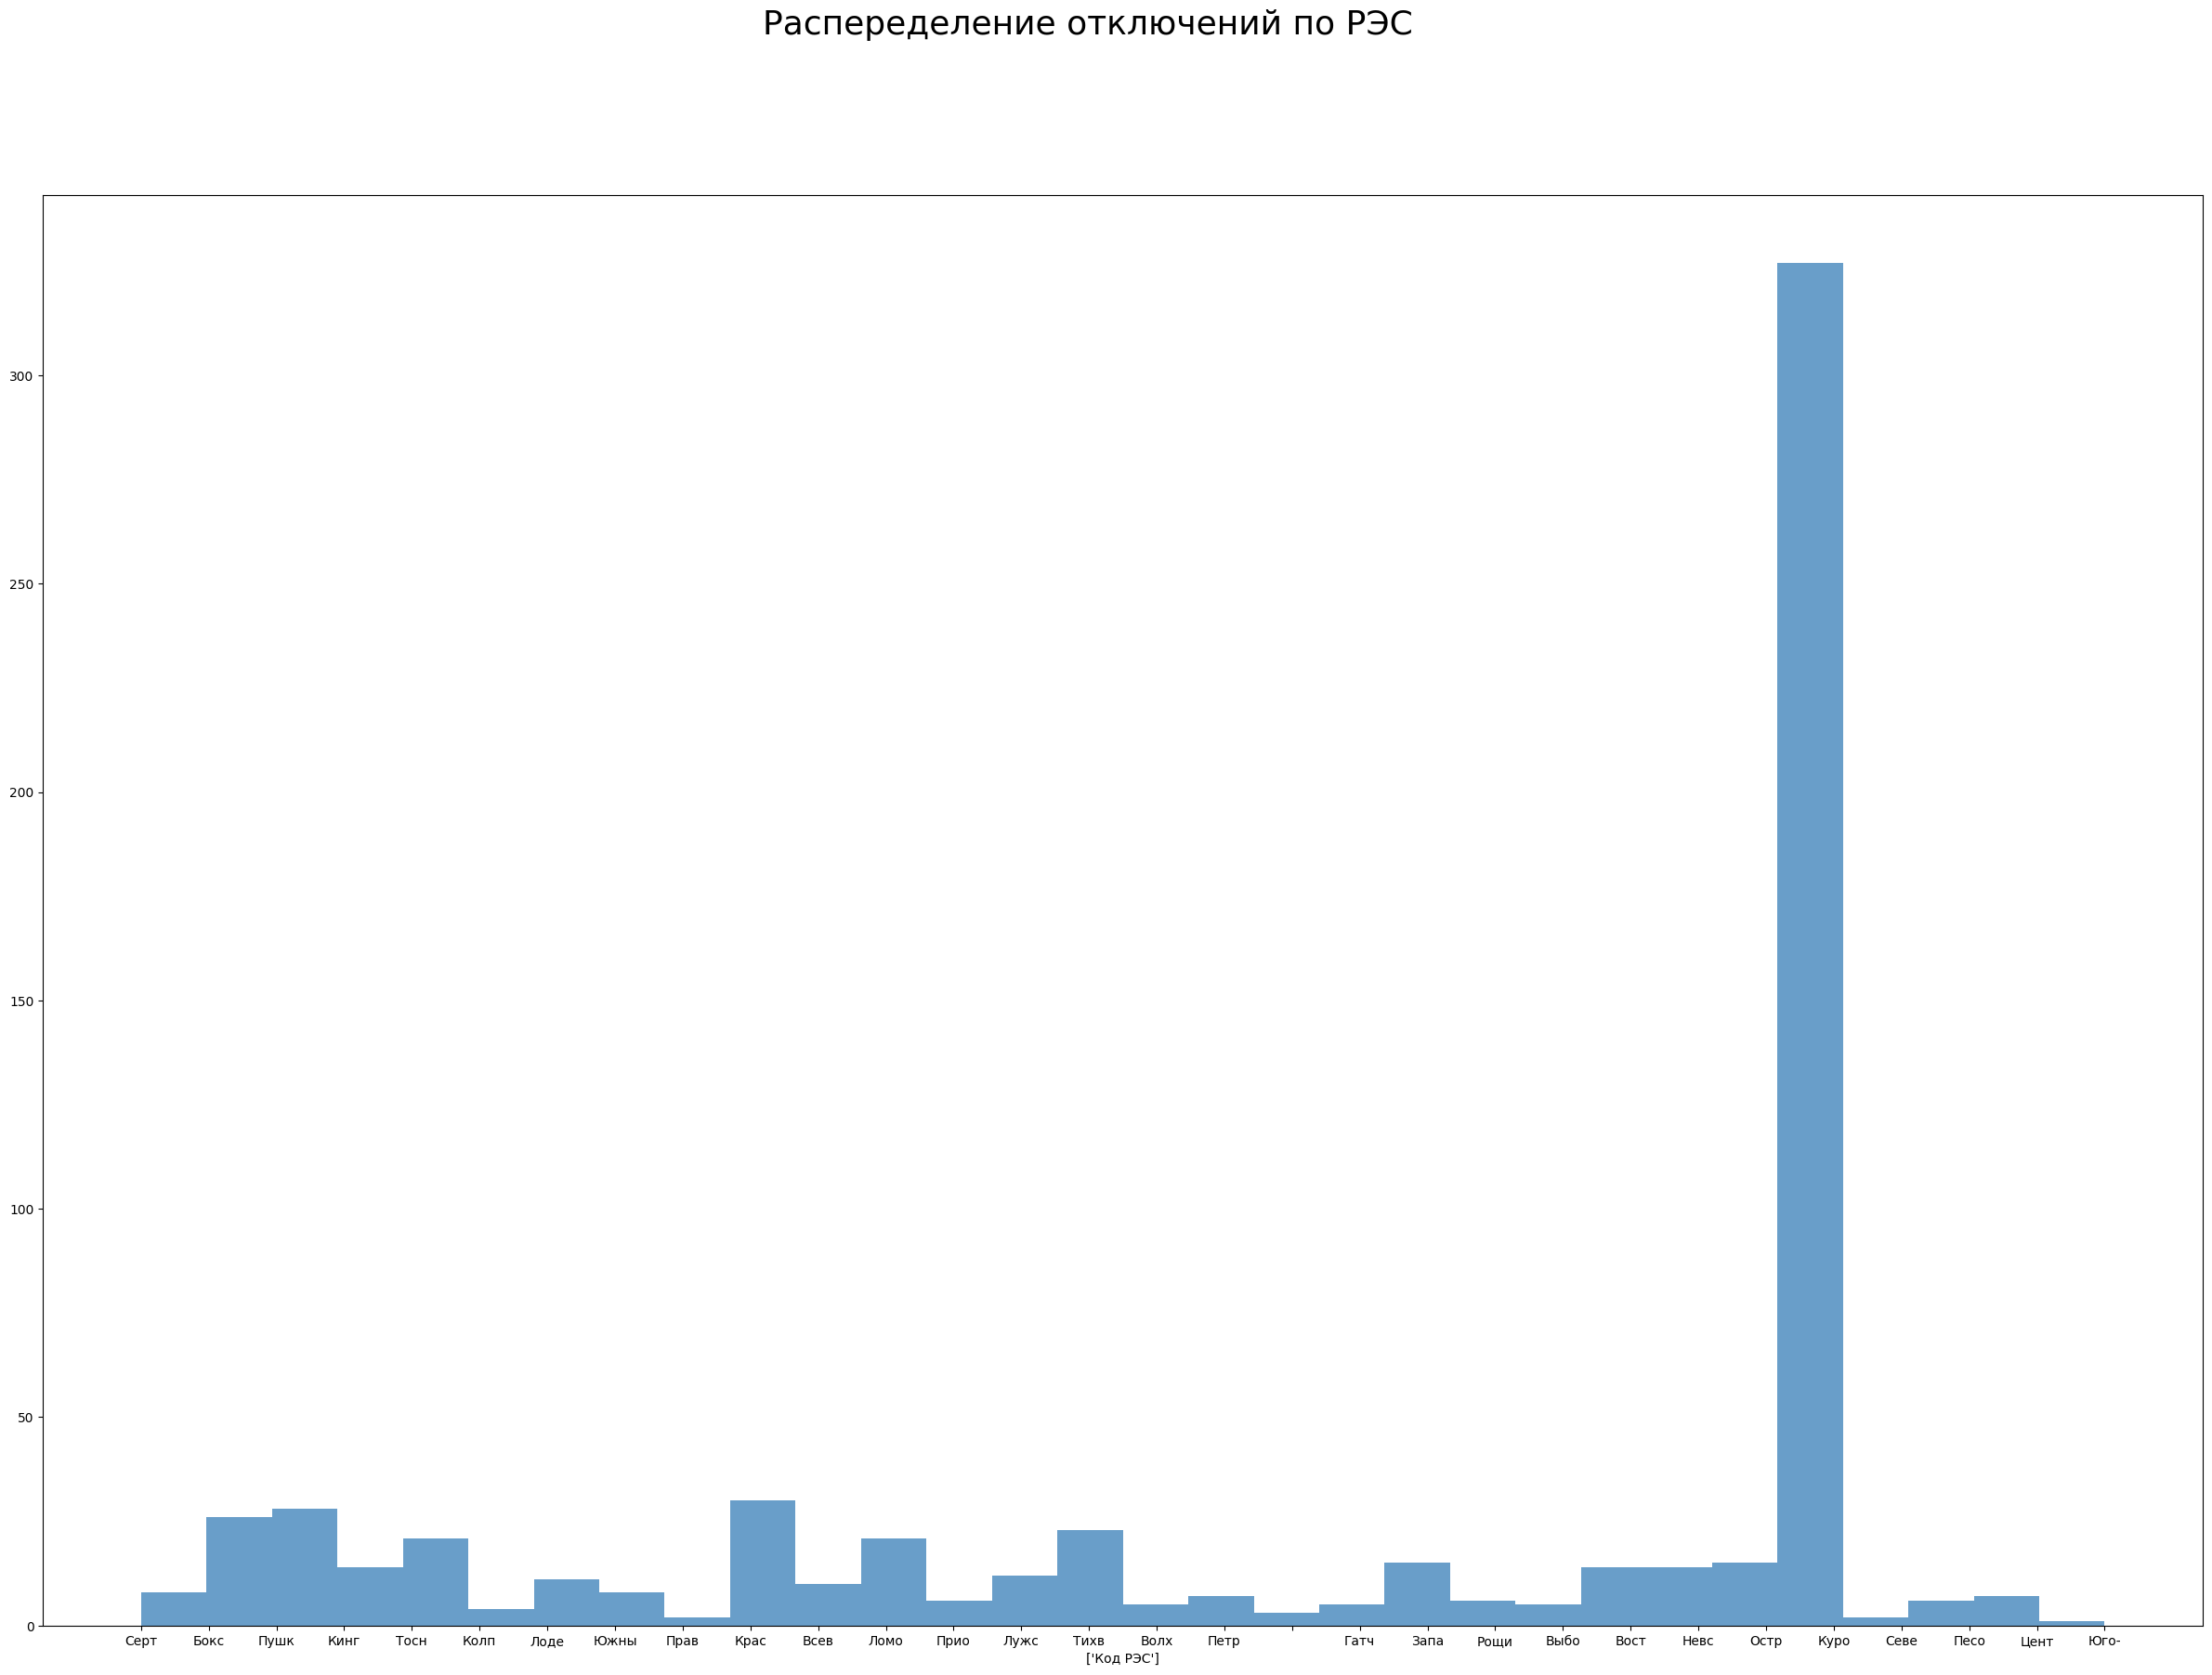

In [20]:
fig, ax = plt.subplots(figsize=(30, 20))
label=['Код РЭС']
ax.set_yscale('linear')   
ax.tick_params(labelsize=10)
ax.set_xlabel(label)
fig.suptitle('Распеределение отключений по РЭС', fontsize=26)

ax.hist(mydata[label], bins=30, color='#377eb8', alpha=.75) # синий 
plt.show()

За сколько отключённых адресов отвественна каждый филиал

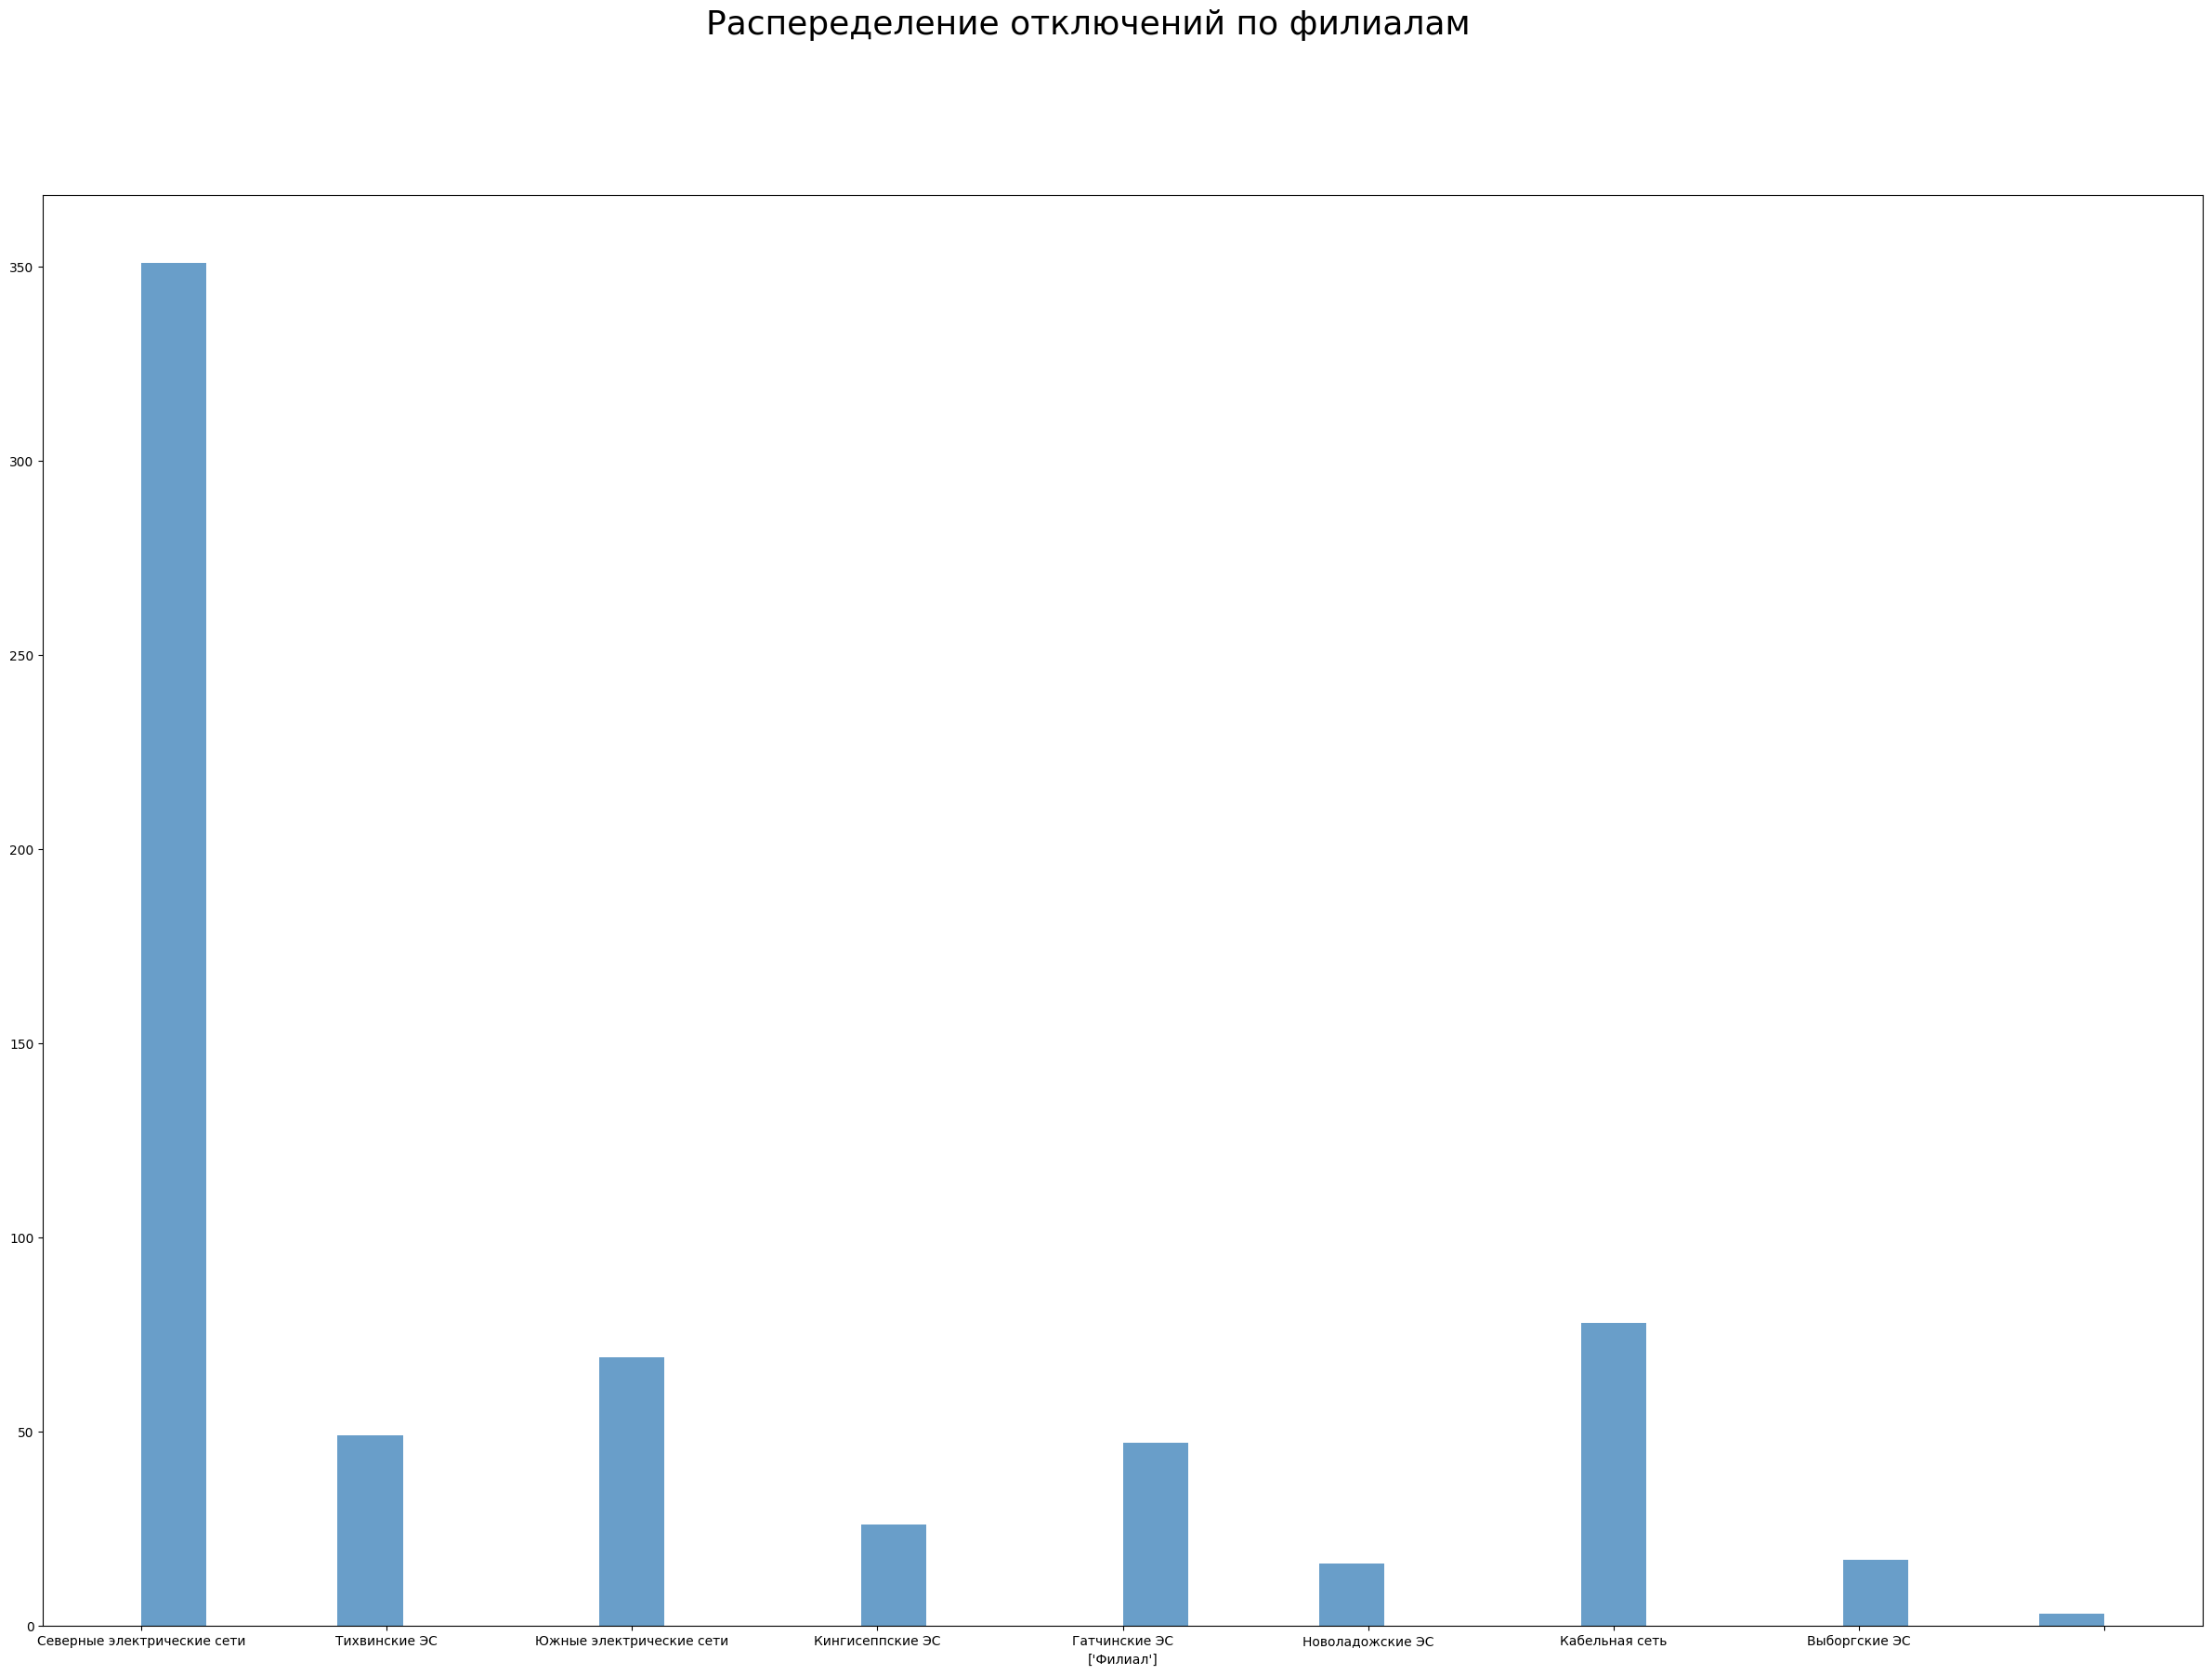

In [21]:
fig, ax = plt.subplots(figsize=(30, 20))
label=['Филиал']
ax.set_yscale('linear')   
ax.tick_params(labelsize=10)
ax.set_xlabel(label)
fig.suptitle('Распеределение отключений по филиалам', fontsize=26)

ax.hist(mydata[label], bins=30, color='#377eb8', alpha=.75) # синий 
plt.show()

Сколько обесточенных адресов каждом районе

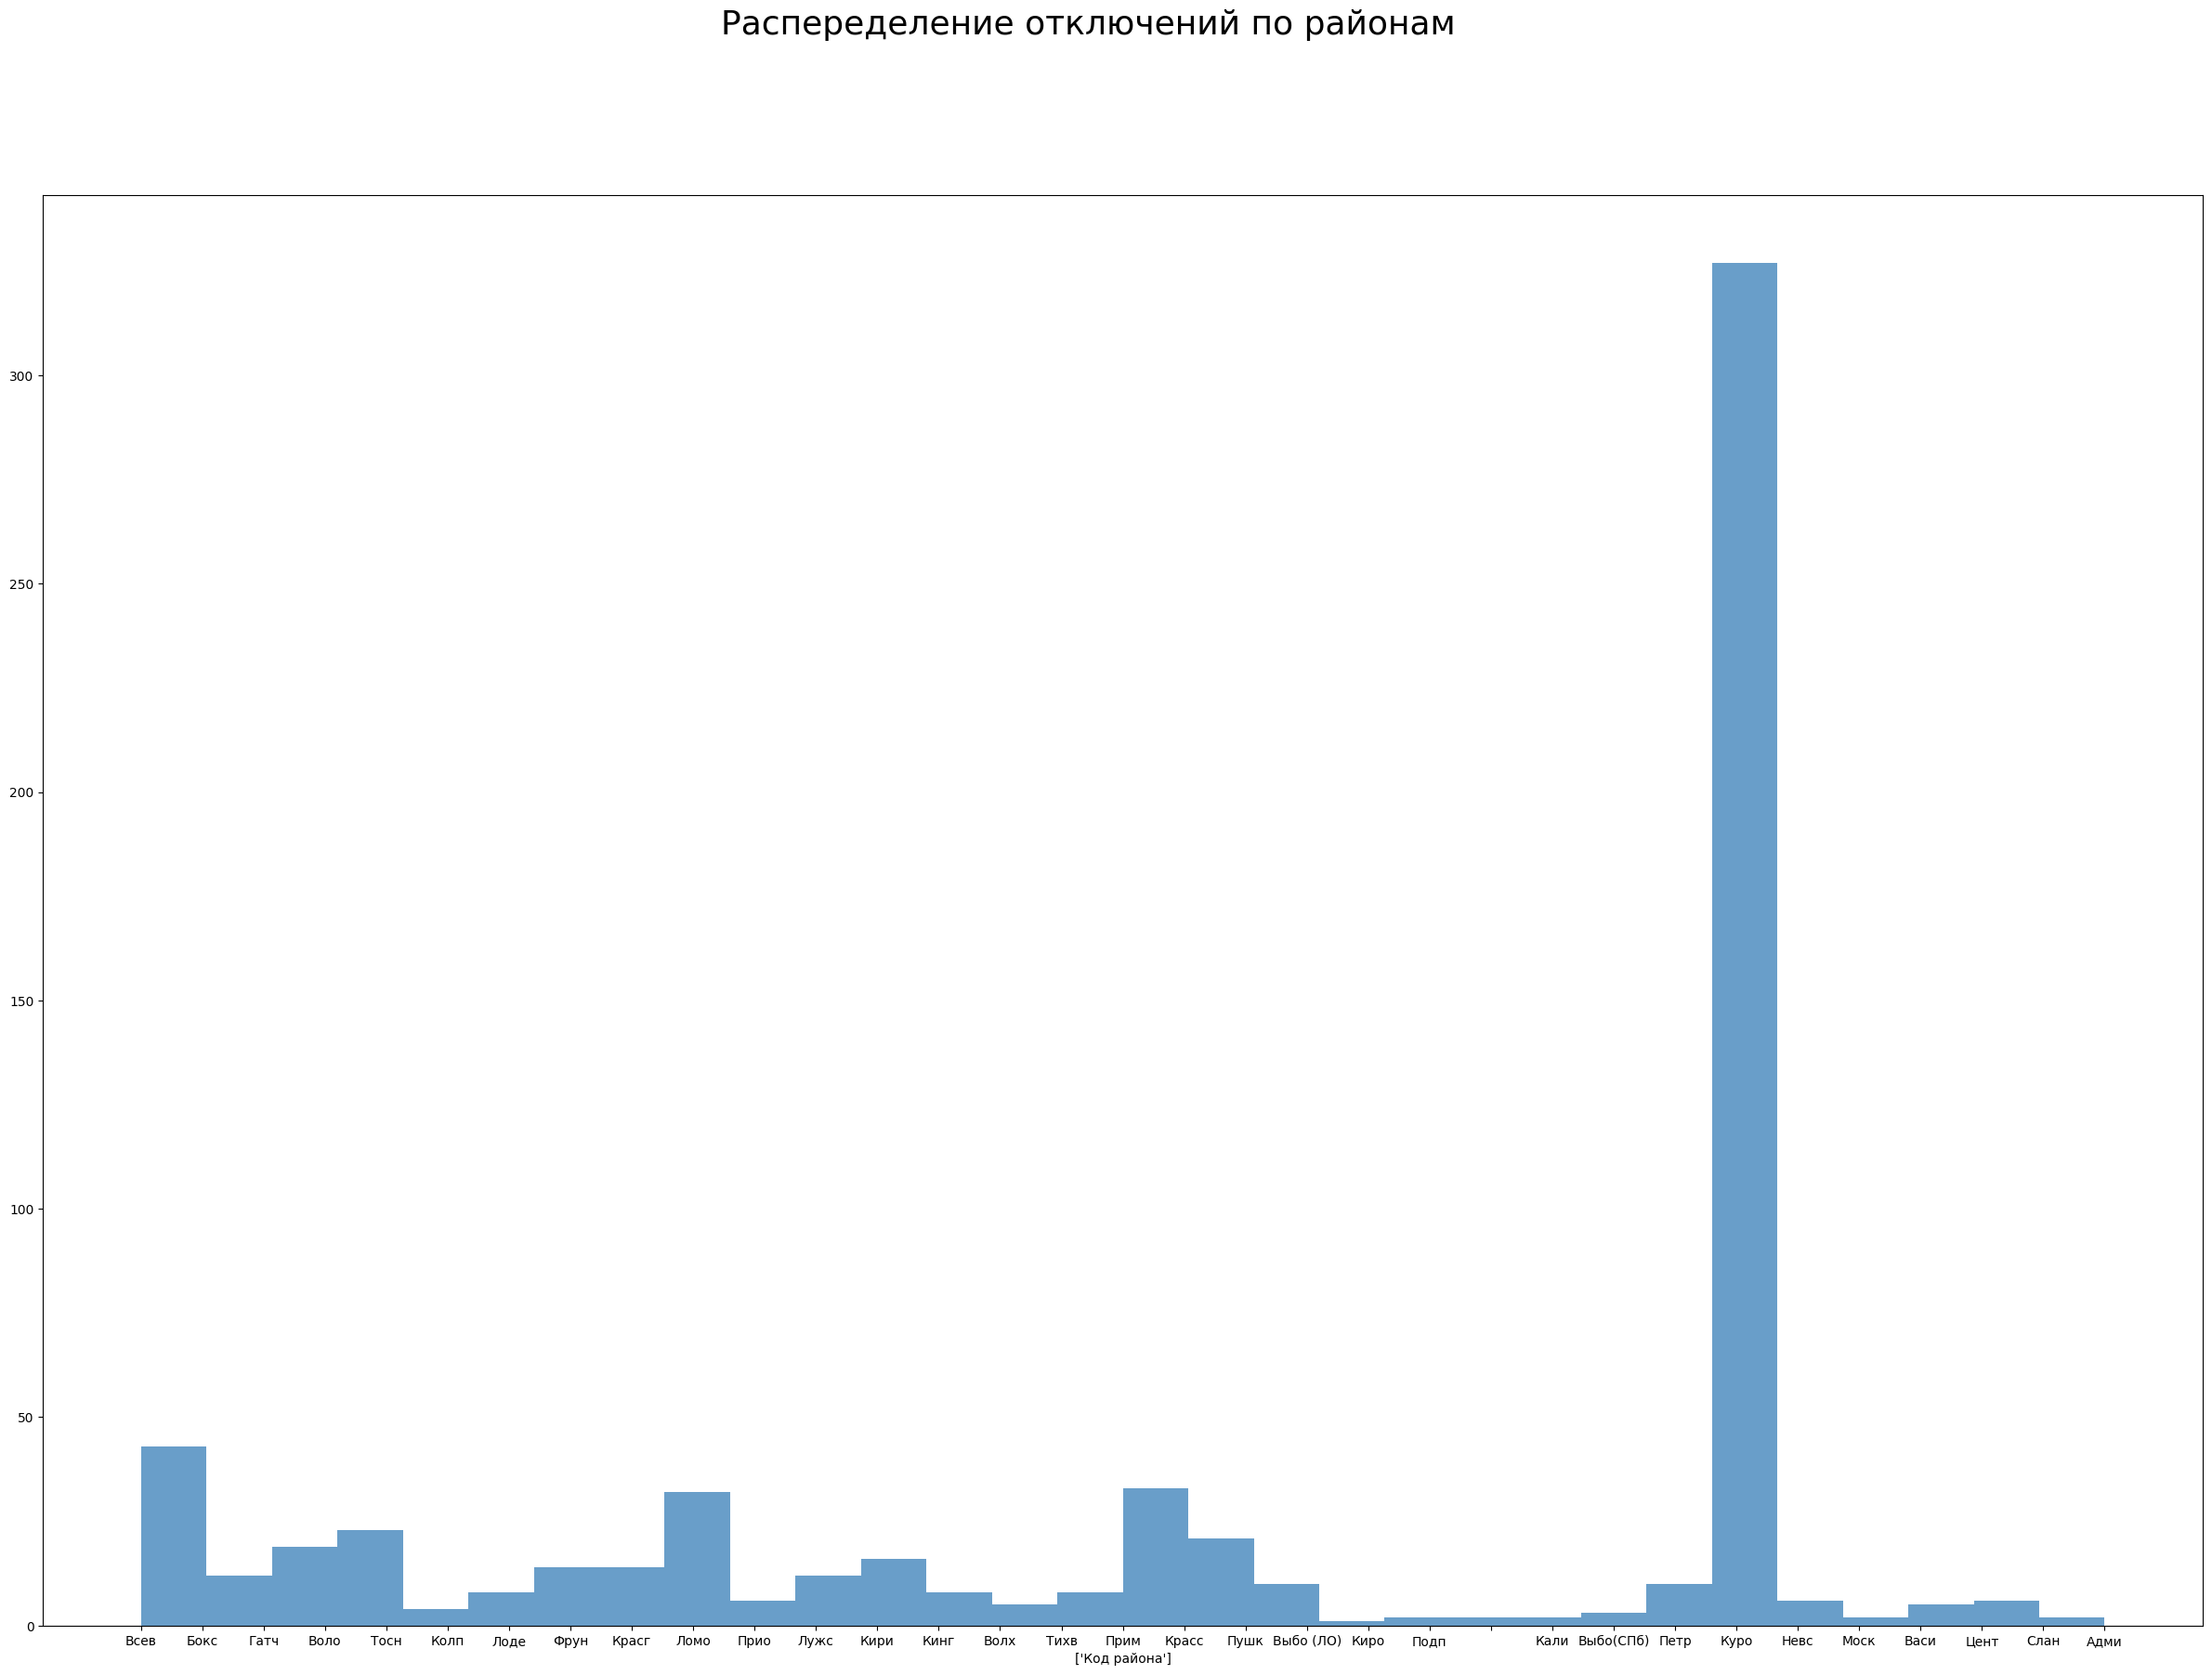

In [22]:
fig, ax = plt.subplots(figsize=(30, 20))
label=['Код района']
ax.set_yscale('linear')   
ax.tick_params(labelsize=10)
ax.set_xlabel(label)
fig.suptitle('Распеределение отключений по районам', fontsize=26)

ax.hist(mydata[label], bins=30, color='#377eb8', alpha=.75) # синий 
plt.show()

Средняя длина отключения по часам

In [23]:
dist_codes = mydata['Код района'].unique()
period_for_dist={}
for d in districts:
    period_for_dist[d]=mydata[mydata['Административный район']==d]['Период отключения(в часах)'].mean()
period_for_dist

{'Всеволожский район': 7.444444444444445,
 'Бокситогорский район': 8.44,
 'Гатчинский район ': 7.333333333333333,
 'Волосовский район': 7.2631578947368425,
 'Тосненский район': 6.521739130434782,
 'Колпинский район': 4.25,
 'Лодейнопольский район': 5.5,
 'Фрунзенский район': 6.071428571428571,
 'Красногвардейский район': 8.357142857142858,
 'Ломоносовский район': 7.5,
 'Приозерский район': 7.333333333333333,
 'Лужский район': 7.583333333333333,
 'Киришский район': 7.5625,
 'Кингисеппский район': 7.75,
 'Волховский район': 8.0,
 'Тихвинский район': 7.75,
 'Приморский район (СПб)': 7.571428571428571,
 'Красносельский район': 8.0,
 'Пушкинский район': 8.80952380952381,
 'Выборгский район (ЛО)': 5.6,
 'Кировский район (ЛО)': 8.0,
 'Подпорожский район': 5.5,
 '': 7.0,
 'Калининский район': 9.0,
 'Выборгский район (СПб)': 6.333333333333333,
 'Петроградский район': 6.4,
 'Курортный район': 11.0,
 'Невский район': 5.833333333333333,
 'Московский район': 5.5,
 'Василеостровский район': 8.0,
 'Ц

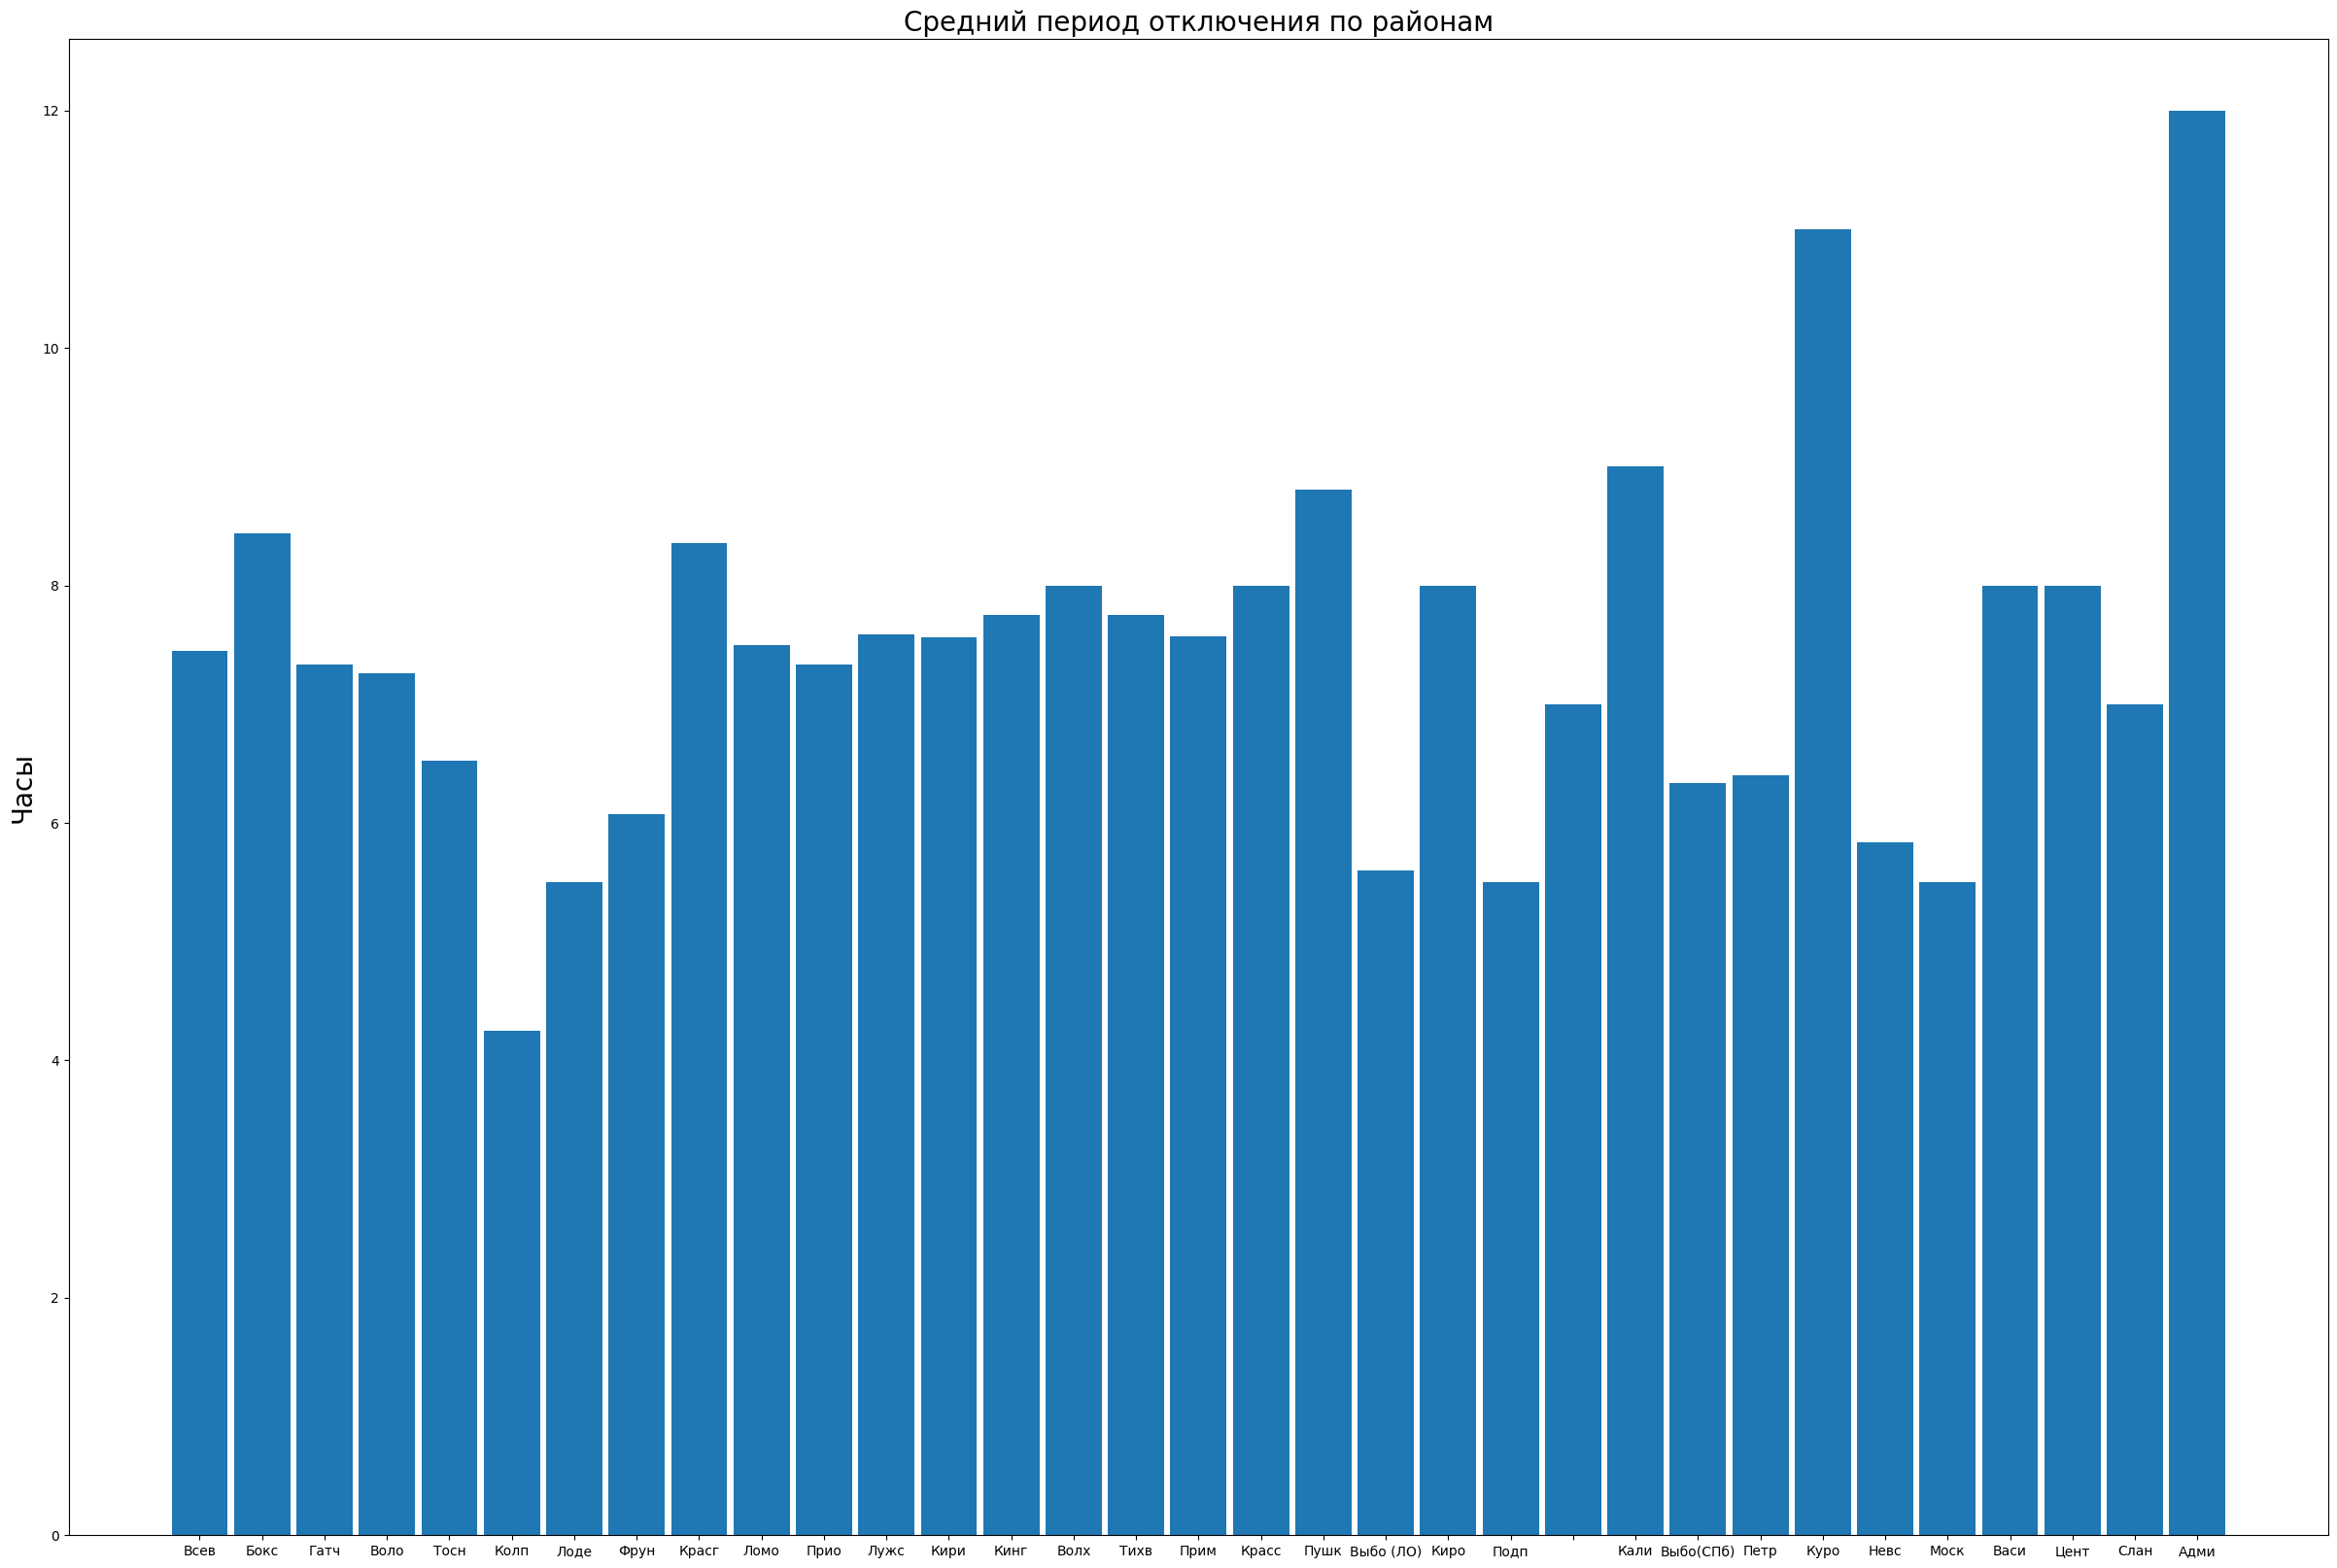

In [24]:
fig, ax = plt.subplots(figsize=(30, 20))
plt.title('Средний период отключения по районам',fontsize=20)
plt.bar(np.arange(len(period_for_dist)),period_for_dist.values(),width=0.9)
plt.xticks(np.arange(len(period_for_dist)),dist_codes, rotation=0)
plt.ylabel('Часы', fontsize=20)
plt.show()

In [25]:
mydata.to_csv('planned_works_Rosseti_changed.csv', index=False)
mydata_copy=mydata.copy()
mydata_copy

,"Регион РФ(область, край, город фед. значения, округ)",Административный район,Населённый пункт,Улица,Филиал,РЭС,Комментарий,Id здания,Координаты,Время начала отключения,Время восстановления отключения,Код района,Код РЭС,Период отключения(в часах)
3,Ленинградская область,Всеволожский район,"пром зона Птице фабрика невская, д. Аньялово.",,Северные электрические сети,Сертоловский РЭС,,NaN,NaN,2023-09-25 10:00:00,2023-09-25 17:00:00,Всев,Серт,7
7,Ленинградская область,Бокситогорский район,"д. Васьково, д.Максимово, д. Платаново, д. О...",,Тихвинские ЭС,Бокситогорский РЭС,,NaN,NaN,2023-09-25 10:00:00,2023-09-25 13:00:00,Бокс,Бокс,3
8,Ленинградская область,Гатчинский район,"д. Покровская, д. Антелево",,Южные электрические сети,Пушкинский РЭС,,NaN,NaN,2023-09-25 10:00:00,2023-09-25 17:00:00,Гатч,Пушк,7
11,Ленинградская область,Волосовский район,"Пружицы, Голятицы",,Кингисеппские ЭС,Кингисеппский РЭС,,NaN,NaN,2023-09-25 09:00:00,2023-09-25 17:00:00,Воло,Кинг,8
13,Ленинградская область,Тосненский район,г.Любань,"Октября, Калинина, Чкалова, Пушкина",Гатчинские ЭС,Тосненский РЭС,Обрезка крон деревьев.,NaN,NaN,2023-09-25 09:00:00,2023-09-25 18:00:00,Тосн,Тосн,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,Санкт-Петербург,Курортный район,п.Солнечное,"Лесная ул, д.11 ,",Северные электрические сети,Курортный РЭС,\nУстановка узла учета,85574.0,"[59.905565613,29.808562492]",2023-09-19 09:00:00,2023-09-19 20:00:00,Куро,Куро,11
730,Санкт-Петербург,Курортный район,п.Солнечное,"Лесная ул, д.1 А",Северные электрические сети,Курортный РЭС,\nУстановка узла учета,33931.0,"[60.167696718,29.830972089]",2023-09-19 09:00:00,2023-09-19 20:00:00,Куро,Куро,11
731,Санкт-Петербург,Курортный район,п.Солнечное,"Лесная ул, д.3 ,",Северные электрические сети,Курортный РЭС,\nУстановка узла учета,52051.0,"[59.880394656,29.842228231]",2023-09-19 09:00:00,2023-09-19 20:00:00,Куро,Куро,11
732,Санкт-Петербург,Курортный район,п.Солнечное,"Лесная ул, д.1",Северные электрические сети,Курортный РЭС,\nУстановка узла учета,33931.0,"[60.167696718,29.830972089]",2023-09-19 09:00:00,2023-09-19 20:00:00,Куро,Куро,11


In [26]:
cat_labels=['Регион РФ(область, край, город фед. значения, округ)','Код района','Филиал','Код РЭС','Населённый пункт']
encoder = {}
for x in cat_labels:
    encoder[x]=LabelEncoder()
    mydata_copy[x] = encoder[x].fit_transform(mydata_copy[x])
mydata_copy.describe()

,"Регион РФ(область, край, город фед. значения, округ)",Населённый пункт,Филиал,Id здания,Код района,Код РЭС,Период отключения(в часах)
count,656.000000,656.000000,656.000000,434.000000,656.000000,656.000000,656.000000
mean,1.681402,122.600610,5.381098,79822.711982,16.882622,12.591463,9.182927
std,0.469551,52.574271,1.824651,55844.396957,6.826527,6.160266,2.308976
min,0.000000,0.000000,0.000000,234.000000,0.000000,0.000000,0.000000
25%,1.000000,72.750000,4.000000,36413.250000,17.000000,11.000000,8.000000
50%,2.000000,162.000000,6.000000,75730.000000,17.000000,11.000000,11.000000
75%,2.000000,162.000000,6.000000,108818.500000,18.250000,14.000000,11.000000
max,2.000000,179.000000,8.000000,224707.000000,32.000000,29.000000,13.000000


C:\Users\Юля\AppData\Local\Temp\ipykernel_4060\510693937.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =corr_df.corr()


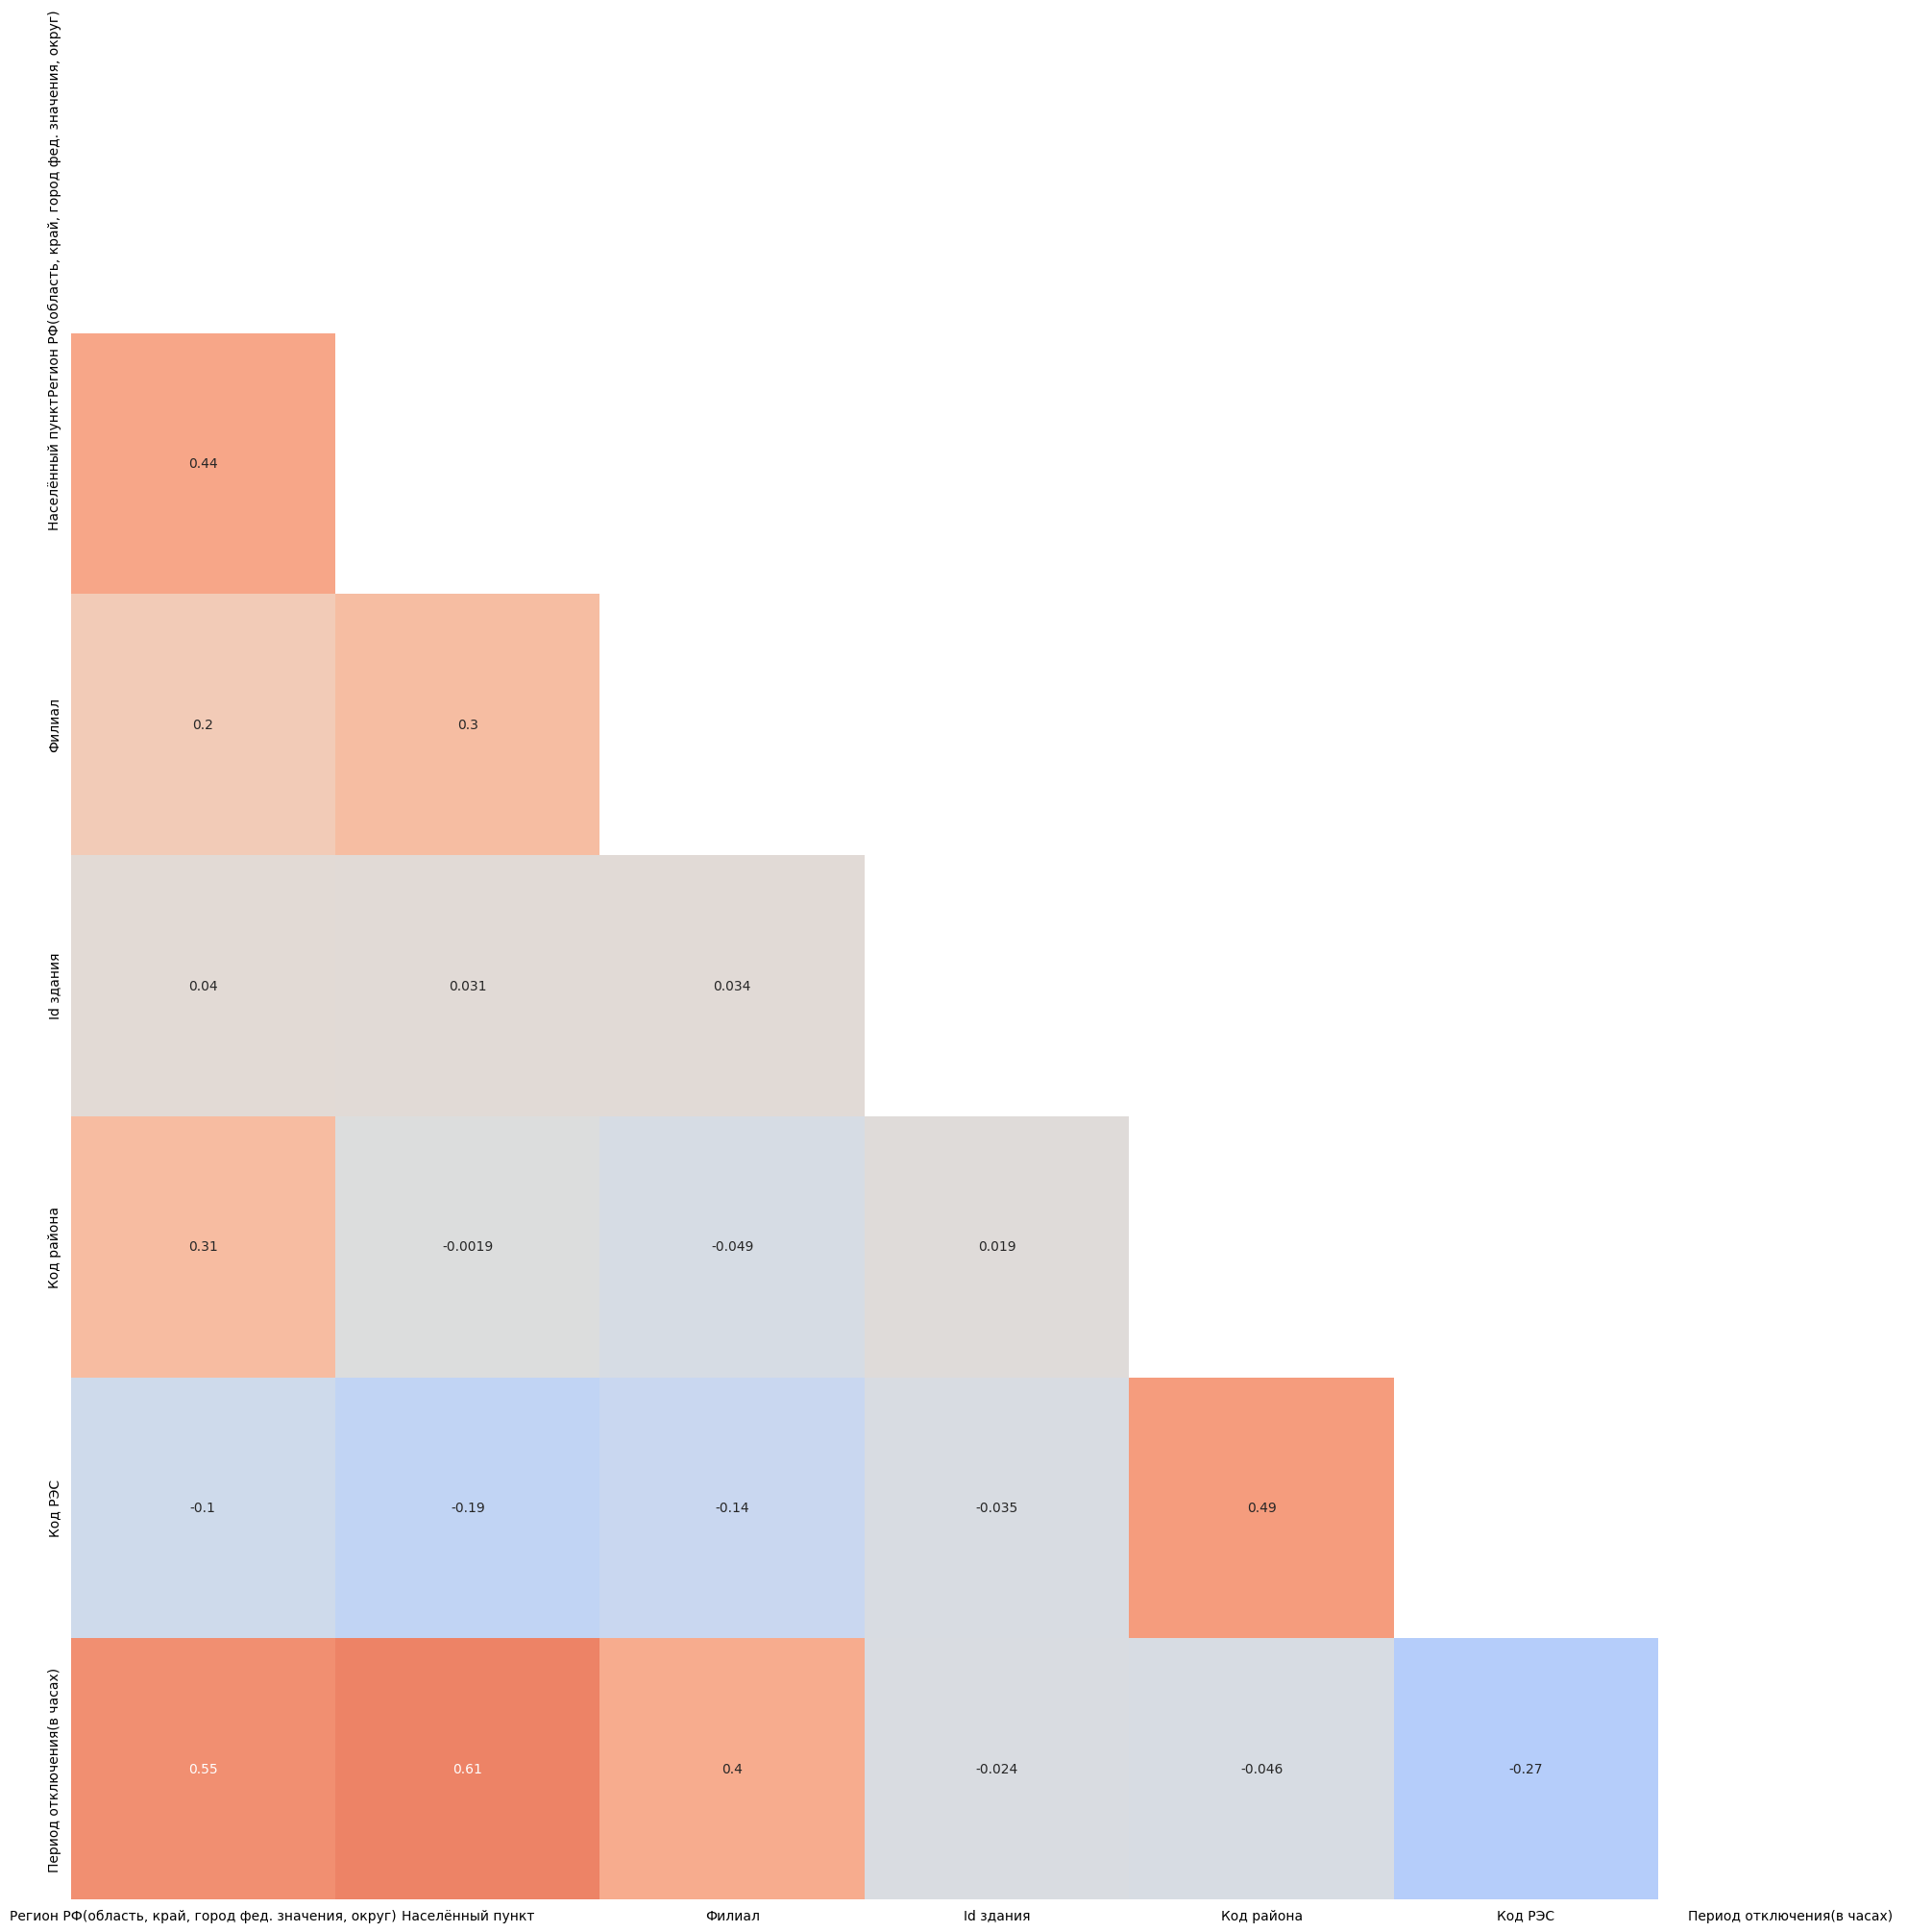

In [27]:
fig, ax = plt.subplots(figsize=(20, 20), constrained_layout=True)
corr_df=mydata_copy
corr =corr_df.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cbar=False, mask=mask,ax=ax,annot=True, cmap='coolwarm',vmin=-1,vmax=1)
ax.tick_params(top=False,bottom=False,left=False,right=False,)

Количество обесточенных домов по датам и предсказание отключения

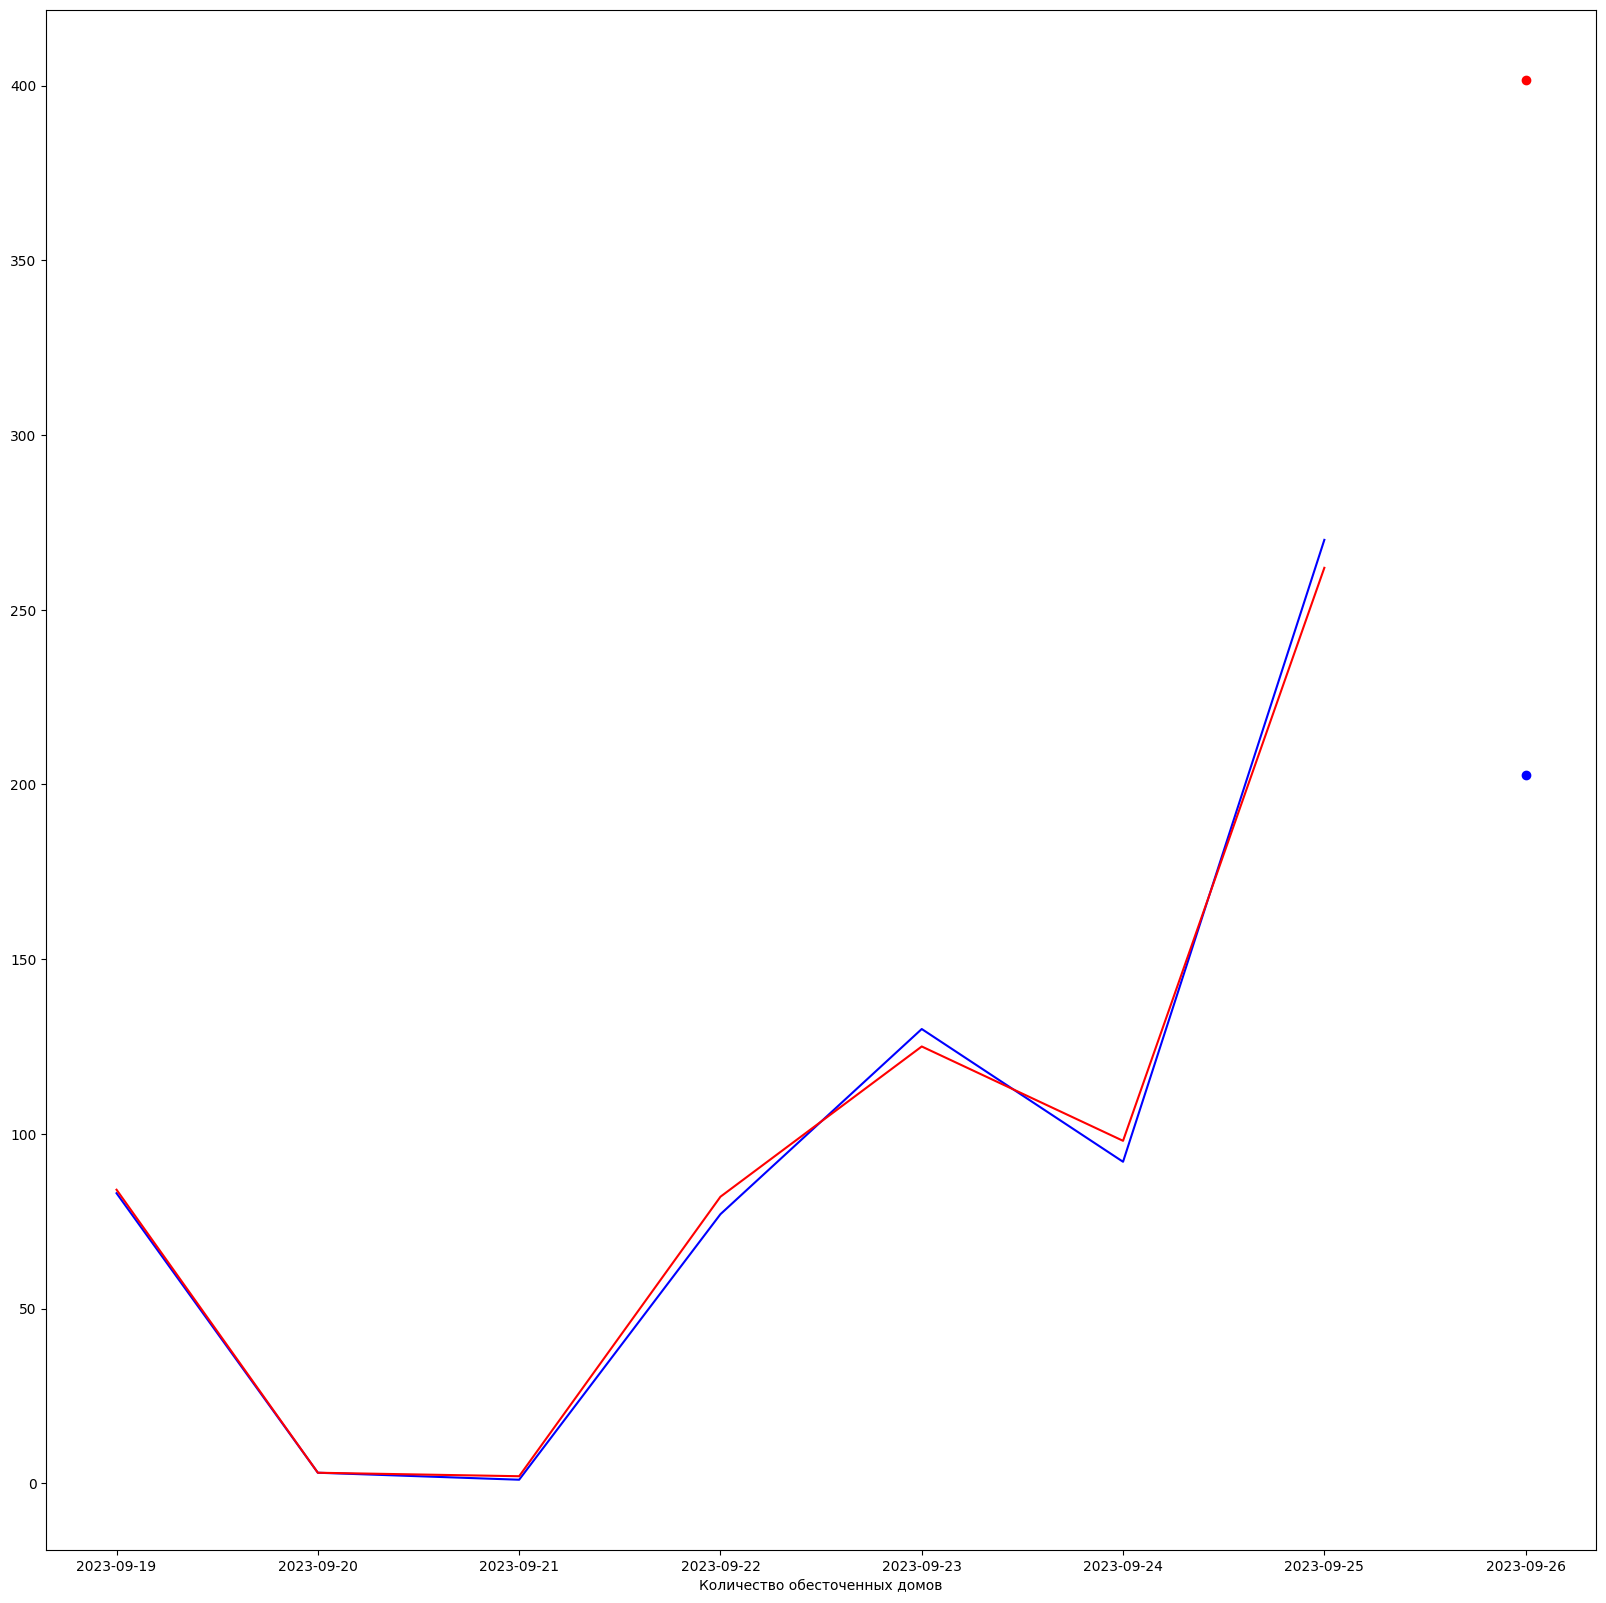

In [28]:
counter=[[],[]]
labels=['Время начала отключения', 'Время восстановления отключения']
dates=[]
dates= mydata[labels[0]].dt.date.unique()
for date in dates:
    for i in range(2):
        counter[i].append(len(mydata[mydata[labels[i]].dt.date==date]))
dates.sort()

weights=[0.6, 0.3, 0.1]
result =0.0
results=[]
for count in counter:
    for n in range(len(weights)):
        result += pd.Series(count).iloc[-n-1] * weights[n]
    result = float(result)
    results.append(result)
    
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_xlabel('Количество обесточенных домов')
ax.plot(dates,counter[0],color='blue')
ax.plot(dates,counter[1],color='red')
dates = np.append(dates,dates[len(dates)-1]+datetime.timedelta(days=1))
plt.scatter(dates[len(dates)-1],results[0],color='blue')
plt.scatter(dates[len(dates)-1],results[1],color='red')
plt.show()

In [29]:
mydata_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656 entries, 3 to 733
Data columns (total 14 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   Регион РФ(область, край, город фед. значения, округ)  656 non-null    int32         
 1   Административный район                                656 non-null    object        
 2   Населённый пункт                                      656 non-null    int32         
 3   Улица                                                 656 non-null    object        
 4   Филиал                                                656 non-null    int32         
 5   РЭС                                                   656 non-null    object        
 6   Комментарий                                           656 non-null    object        
 7   Id здания                                             434 non-null    float64   

In [30]:
mydata_copy['Время начала отключения']= mydata_copy['Время начала отключения'].astype('int64')
mydata_copy['Время восстановления отключения']= mydata_copy['Время начала отключения'].astype('int64')

In [31]:
mydata_copy

,"Регион РФ(область, край, город фед. значения, округ)",Административный район,Населённый пункт,Улица,Филиал,РЭС,Комментарий,Id здания,Координаты,Время начала отключения,Время восстановления отключения,Код района,Код РЭС,Период отключения(в часах)
3,1,Всеволожский район,173,,6,Сертоловский РЭС,,NaN,NaN,1695636000000000000,1695636000000000000,6,24,7
7,1,Бокситогорский район,86,,7,Бокситогорский РЭС,,NaN,NaN,1695636000000000000,1695636000000000000,2,1,3
8,1,Гатчинский район,97,,8,Пушкинский РЭС,,NaN,NaN,1695636000000000000,1695636000000000000,9,21,7
11,1,Волосовский район,42,,4,Кингисеппский РЭС,,NaN,NaN,1695632400000000000,1695632400000000000,4,8,8
13,1,Тосненский район,85,"Октября, Калинина, Чкалова, Пушкина",2,Тосненский РЭС,Обрезка крон деревьев.,NaN,NaN,1695632400000000000,1695632400000000000,30,26,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,2,Курортный район,169,"Лесная ул, д.11 ,",6,Курортный РЭС,\nУстановка узла учета,85574.0,"[59.905565613,29.808562492]",1695114000000000000,1695114000000000000,17,11,11
730,2,Курортный район,169,"Лесная ул, д.1 А",6,Курортный РЭС,\nУстановка узла учета,33931.0,"[60.167696718,29.830972089]",1695114000000000000,1695114000000000000,17,11,11
731,2,Курортный район,169,"Лесная ул, д.3 ,",6,Курортный РЭС,\nУстановка узла учета,52051.0,"[59.880394656,29.842228231]",1695114000000000000,1695114000000000000,17,11,11
732,2,Курортный район,169,"Лесная ул, д.1",6,Курортный РЭС,\nУстановка узла учета,33931.0,"[60.167696718,29.830972089]",1695114000000000000,1695114000000000000,17,11,11


Какие населёные пункты ждёт отключение

In [32]:
labels_drop=['Административный район','Улица','РЭС','Комментарий','Координаты']
X=mydata_copy.drop(labels_drop, axis=1)
X.drop('Населённый пункт',axis=1)
y=mydata_copy['Населённый пункт']
X=X.fillna(-999)
y=y.fillna(-999)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)
accuracy = model.score(X_test,y_test)
print(accuracy)
predictions = model.predict(X_test)
print(predictions.astype(int))

0.9999998930848462
[161  44   1 162 161 162 162  99 161 162 101  81  91  10 161 162 162 172
 165 171  34 172 106 162  56 138 171  22 172 161  45  95  99 162 145 162
  49  73  30  28 171 141  57  79 161 171  82 162 162 161 161 162 162  55
  58 116 162  34 171 172 127 162  27  94 171 171  84 162  73 108 162  57
 162  57 171  34 162  79 162 171  49 162 161 161 162  39  40 161 120 162
  77  20 162 161  79 171 172 153 162  44  80 162 172  81 162 162 161 162
  56  68  57 110 171 161 162  86 169  84 114 161 171 162 162 128  36  67
 161 100 123  76  57  56 177 144   2  35 134  57 161  81 171 172 162 144
 162 161 162 161  57 171 161  57 171  29  59 171 162 162  37  56  12 162
 161 162  84 124 163 109 162 161 171 161 162 178  85 162  25  18   6 162
 113  35  98 160  56 161 172 113 175 171  22 128  43 162  82 129 115]


In [33]:
towns= encoder['Населённый пункт'].inverse_transform(predictions.astype(int))
print('Какие населёные пункты ждёт отключение:\n')
for i in range(10):
    print(pd.Series(towns).value_counts().index[i])

Какие населёные пункты ждёт отключение:

п.Лисий Нос
п.Комарово
п.Тракторное
п.Ушково
Санкт-Петербург
СТ Рассвет
г. Пушкин,  п. Александровская
г.Зеленогорск
г. Павловск
Куколь,  Конец,  Заднево,  Нивы,  Дяглево,  Ежева,  Юрцево,  Монцево,  Великое село,  Хамонтово,  Коскеницы,  Колчаново


Какие РЭС вероятно отключат электроснабжение

In [34]:
y=mydata_copy['Код РЭС']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)
accuracy = model.score(X_test,y_test)
print(accuracy)
predictions = model.predict(X_test)
print(predictions.astype(int))

0.9999998863106369
[11 11 11 13 11  7 11 15 15 18 21 21  3 10 11  7 11 21 11 11 11 14 11 11
 11 11 13 11 11  8 11 11 11 18 10 26  8 21 11 26 22 11 11 11 24 11 21 16
 11 11 11 11  1 10  7 11 21  3 26 11 11 24 21 11 14 10 26 11 11 11 11 13
 11 10 25 11 11 16 25 11 11 11 11 11 11 11 13 13 16  1 11 21 11 11 21 11
  9 10 25  3 21 11 24 15 10 11 26 19 11 11  2 11 14 16  7 11  5 23 29 11
 11 11 11 11 11 21 11 11 15 11 11 11  5 11 11 10 11 11 16  7 15  3 22  1
 10 11 11 10 11 11 11 10  4 26 11 19 10 11 11 18 10 11 11  1 11 27 16 11
  1 11 11  8 11 11 11  2 15 16  7 11 11 27 21 13 21 25 27  9 11 25 21  6
 12  7 11  1 25]


In [35]:
predictions=predictions.astype(int)
print('Какие РЭС вероятно отключат электроснабжение:\n')
for i in range(10):
    d=mydata_copy[mydata_copy['Код района']== pd.Series(predictions).value_counts().index[i]]['Административный район'].iloc[:1].to_numpy()
    if d.size>0:
        print(d[0])

Какие РЭС вероятно отключат электроснабжение:

Кингисеппский район
Московский район
Калининский район
Красносельский район
Выборгский район (ЛО)
Приморский район (СПб)
Кировский район (ЛО)
Красногвардейский район
Приозерский район
Адмиралтейский район


In [36]:
!pip install pipreqsnb
import pipreqsnb 

In [37]:
!pipreqsnb .

pipreqs  .